In [34]:
import warnings
warnings.filterwarnings("ignore")

from zlib import crc32
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, KFold

import json
from math import nan

from torchvision import datasets
from torchvision import transforms

from sklearn.model_selection import ParameterGrid


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
types = ['regression', 'classification']
datasets_dict = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'},
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'},
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'},
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'},
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'},
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия',
                          'Перцептрон',
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия',
                              'Перцептрон',
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна',
                              'SVM']}
task = dict()
task['mail'] = "nikitin.sa@phystech.edu" # input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets_dict[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()


task

{'mail': 'nikitin.sa@phystech.edu',
 'id': 1522662506,
 'type': 'classification',
 'dataset': {'name': 'MNIST', 'url': 'http://yann.lecun.com/exdb/mnist/'},
 'method': ['Логистическая регрессия', 'SVM', 'Метод Парзеновского окна']}

## Анализ выборки

In [3]:
download = True

MNIST_train = datasets.MNIST('./mnist', train=True, download=download,
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=download,
                            transform=transforms.ToTensor())

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 15889770.35it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 483805.46it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4403452.90it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3503223.39it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



#### Описание датасета

* База данных рукописных цифр MNIST, доступная на этой странице, содержит обучающий набор из 60 000 примеров и тестовый набор из 10 000 примеров.
* Цифры нормализованы по размеру и центрированы на изображении фиксированного размера (28 x 28 пикселей/параметров).
* Значения пикселей изображений обучающего и тестового наборов являются **целыми числами** от 0 до 255. 0 означает фон (черный), 255 означает передний план (белый).
* Значения меток — целое число от 0 до 9.

In [ ]:
print(
    f"Size of training data database: \t{MNIST_train.data.numpy().shape}\t\t[data type: {MNIST_train.data.numpy().dtype}]\n" \
    f"Size of training targets database: \t{MNIST_train.targets.numpy().shape}\t\t[data type: {MNIST_train.targets.numpy().dtype}]\n\n" \
    f"Size of testing data database: \t\t{MNIST_test.data.numpy().shape}\t\t[data type: {MNIST_test.data.numpy().dtype}]\n" \
    f"Size of testing targets database: \t{MNIST_test.targets.numpy().shape}\t\t[data type: {MNIST_test.targets.numpy().dtype}]"
)

Size of training data database: 	(60000, 28, 28)		[data type: uint8]
Size of training targets database: 	(60000,)		[data type: int64]

Size of testing data database: 		(10000, 28, 28)		[data type: uint8]
Size of testing targets database: 	(10000,)		[data type: int64]


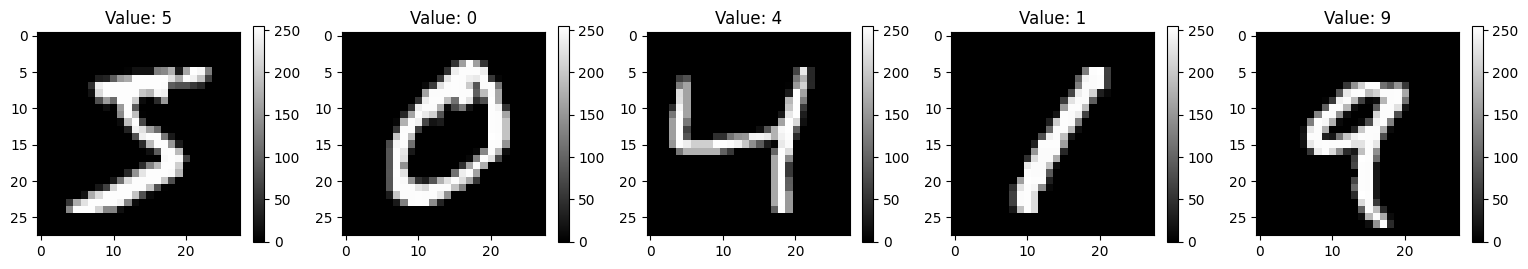

In [ ]:
# Визуализация нескольких изображений из набора данных
def visualize_samples(X, y, num_samples=5):
    plt.figure(figsize=(19, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        pos = plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.colorbar(pos, anchor=(0.0, 0.5), shrink=0.7)
        plt.title(f'Value: {y[i]}')
    plt.show()

visualize_samples(MNIST_train.data.numpy(), MNIST_train.targets.numpy())

## Препроцессинг данных

Преобразовал категориальные данные в вещественные и отнормировал. Также сократил размер обучающей выборки до 10000 примеров для ускорения вычислений.

In [4]:
X_train = MNIST_train.data.numpy().reshape(MNIST_train.data.shape[0], 28*28)[:10000,:].astype('float32') / 255.0
Y_train = MNIST_train.targets.numpy().astype('uint8')[:10000]
X_test = MNIST_test.data.numpy().reshape(MNIST_test.data.shape[0], 28*28).astype('float32') / 255.0
Y_test = MNIST_test.targets.numpy().astype('uint8')

In [ ]:
print(
    f"Size of training data database: \t{X_train.shape}\t\t[data type: {X_train.dtype}]\n" \
    f"Size of training targets database: \t{Y_train.shape}\t\t[data type: {Y_train.dtype}]\n\n" \
    f"Size of testing data database: \t\t{X_test.shape}\t\t[data type: {X_test.dtype}]\n" \
    f"Size of testing targets database: \t{Y_test.shape}\t\t[data type: {Y_test.dtype}]"
)

Size of training data database: 	(10000, 784)		[data type: float32]
Size of training targets database: 	(10000,)		[data type: uint8]

Size of testing data database: 		(10000, 784)		[data type: float32]
Size of testing targets database: 	(10000,)		[data type: uint8]


## Проведение экспериментов для нескольких методов классификации ('Логистическая регрессия', 'SVM', 'Метод Парзеновского окна')

In [5]:
def draw_table(data, title=['ACCURACY'], width=[100, 11]):
    row_format     = '|' + '|'.join([("{:>" + str(w) + "}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>" + str(w) + "}") for w in width]) + '+'

    print(row_format_bet.format(
        "-" * width[0], *["-" * width[i + 1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-" * width[0], *["-" * width[i + 1] for i, _ in enumerate(title)]))

    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0] + 3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 3) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-" * width[i + 1] for i, _ in enumerate(title)]))

### Логистическая регрессия

In [ ]:
# Подбор гипперпараметра gamma с регуляризатором penalty через Cross Validation метод

def get_scores_LogReg(cross_val:KFold, grid:ParameterGrid, X_train, Y_train, number_of_batch:int) -> dict[str, list[float]]:
    scores = dict()

    for item in tqdm(grid):
        list_of_scores = []
        for train_index, test_index in tqdm(cross_val.split(X_train), total=number_of_batch, leave=False):
            x_train, x_test = X_train[train_index], X_train[test_index]
            y_train, y_test = Y_train[train_index], Y_train[test_index]

            model = LogisticRegression(penalty=item['penalty'], C=2/item['gamma'], solver='saga', fit_intercept=False, random_state=0)
            model.fit(x_train, y_train)
            list_of_scores.append(model.score(x_test, y_test))

        scores[str(item)] = [np.mean(list_of_scores)]

    return scores

In [ ]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'penalty': ['l1', 'l2'],
                      'gamma': [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]})

scores = get_scores_LogReg(cross_val, grid, X_train, Y_train, number_of_batch)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
draw_table(scores, width=[50, 11])

+--------------------------------------------------+-----------+
|                                                  |   ACCURACY|
+--------------------------------------------------+-----------+
|                 {'gamma': 1e-10, 'penalty': 'l1'}|      0.897|
+--------------------------------------------------+-----------+
|                 {'gamma': 1e-10, 'penalty': 'l2'}|      0.897|
+--------------------------------------------------+-----------+
|                {'gamma': 0.0001, 'penalty': 'l1'}|      0.897|
+--------------------------------------------------+-----------+
|                {'gamma': 0.0001, 'penalty': 'l2'}|      0.897|
+--------------------------------------------------+-----------+
|                 {'gamma': 0.001, 'penalty': 'l1'}|      0.897|
+--------------------------------------------------+-----------+
|                 {'gamma': 0.001, 'penalty': 'l2'}|      0.897|
+--------------------------------------------------+-----------+
|                  {'gamm

In [ ]:
# Проверка на тестовой выборке

best_score = json.loads(sorted(scores, key=lambda x: scores[x], reverse=True)[0].replace("'", "\""))
print(best_score)

model = LogisticRegression(penalty=best_score['penalty'], C=2/best_score['gamma'], solver='saga',
                                    fit_intercept=False, random_state=0)
model.fit(X_train, Y_train)

print('Точность: {}'.format(model.score(X_test, Y_test)))

{'gamma': 10.0, 'penalty': 'l2'}
Точность: 0.9082


### SVM (Support Vector Machine)

In [7]:
# Подбор гипперпараметров (kernel, gamma, degree) с регуляризатором "C" через Cross Validation метод

def get_scores_SVM(cross_val:KFold, grid:ParameterGrid, X_train:np.array, Y_train:np.array, number_of_batch:int) -> dict[str, list[float]]:
    scores = dict()

    for item in tqdm(grid):
        list_of_scores = []
        for train_index, test_index in tqdm(cross_val.split(X_train), total=number_of_batch, leave=False):
            x_train, x_test = X_train[train_index], X_train[test_index]
            y_train, y_test = Y_train[train_index], Y_train[test_index]

            model = SVC(kernel=item['kernel'], gamma=item['gamma'],
                        C=item['C'], degree=item['poly_degree'])
            model.fit(x_train, y_train)
            list_of_scores.append(model.score(x_test, y_test))

        scores[str(item)] = [np.mean(list_of_scores)]

    return scores

In [8]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(X_train)

# Параметр 'poly_degree' используется только при kernel = 'poly'
grid = ParameterGrid({'C': [4.0, 5.0, 8.0, 14.0, 25.0, 40.0],
                      'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
                      'poly_degree': [1, 2, 3, 4],
                      'gamma': ['scale', 'auto', 0.1, 0.3]
                      })

scores = get_scores_SVM(cross_val, grid, X_train, Y_train, number_of_batch)

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
draw_table(scores)

+----------------------------------------------------------------------------------------------------+-----------+
|                                                                                                    |   ACCURACY|
+----------------------------------------------------------------------------------------------------+-----------+
|                                  {'C': 4.0, 'gamma': 'scale', 'kernel': 'linear', 'poly_degree': 1}|      0.912|
+----------------------------------------------------------------------------------------------------+-----------+
|                                  {'C': 4.0, 'gamma': 'scale', 'kernel': 'linear', 'poly_degree': 2}|      0.912|
+----------------------------------------------------------------------------------------------------+-----------+
|                                  {'C': 4.0, 'gamma': 'scale', 'kernel': 'linear', 'poly_degree': 3}|      0.912|
+-------------------------------------------------------------------------------

In [10]:
# Проверка на тестовой выборке

best_score = json.loads(sorted(scores, key=lambda x: scores[x], reverse=True)[0].replace("'", "\""))
print(best_score)

model = SVC(kernel=best_score['kernel'], gamma=best_score['gamma'], C=best_score['C'], degree=best_score['poly_degree'])
model.fit(X_train, Y_train)

print('Точность: {}'.format(model.score(X_test, Y_test)))

{'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf', 'poly_degree': 1}
Точность: 0.9679


### Метод Парзеновского окна

Гипотеза: модель окна Парзеновского плохо обучится, либо не обучится вовсе на большом количестве параметров (n = 28 * 28 = 784).

In [26]:
def epanechnikov_kernel(distance, h=0.05):
    u = np.array(distance) / h
    return 0.75 * (1 - u ** 2) * (np.abs(u) <= 1)

def triangular_kernel(distance, h=0.05):
    u = np.array(distance) / h
    return (1 - np.abs(u)) * (np.abs(u) <= 1)

def uniform_kernel(distance, h=0.05):
    u = np.array(distance) / h
    return 0.5 * (np.abs(u) <= 1)

def quartic_kernel(distance, h=0.05):
    u = np.array(distance) / h
    return (15/16) * ((1 - u ** 2) ** 2) * (np.abs(u) <= 1)

In [29]:
# Подбор гипперпараметров (h - ширина окна, kernel - тип ядра функции) через Cross Validation метод

def get_scores_ParzenWindow(cross_val:KFold, grid:ParameterGrid, X_train:np.array, Y_train:np.array, \
    number_of_batch:int) -> dict[str, list[float]]:
    scores = dict()

    for item in tqdm(grid):
        list_of_scores = []
        flag = True
        for train_index, test_index in tqdm(cross_val.split(X_train), total=number_of_batch, leave=False):
            x_train, x_test = X_train[train_index], X_train[test_index]
            y_train, y_test = Y_train[train_index], Y_train[test_index]

            try:
              model = KNeighborsClassifier(n_neighbors=len(x_train), weights=lambda x: item['kernel'](x, h=item['h']))
              model.fit(x_train, y_train)
              list_of_scores.append(model.score(x_test, y_test))
            except Exception as err:
              print(err)
              flag = False

        scores[str(item)] = [np.mean(list_of_scores)] if (flag) else [nan]

    return scores

In [30]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(X_train)

grid = ParameterGrid({'kernel': [epanechnikov_kernel, triangular_kernel, uniform_kernel, quartic_kernel],
                      'h': [0.001, 0.07, 0.5, 1, 20, 30, 50, 100]})

scores = get_scores_ParzenWindow(cross_val, grid, X_train, Y_train, number_of_batch)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.
All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
draw_table(scores)

+----------------------------------------------------------------------------------------------------+-----------+
|                                                                                                    |   ACCURACY|
+----------------------------------------------------------------------------------------------------+-----------+
|                            {'h': 0.001, 'kernel': <function epanechnikov_kernel at 0x7c603e832a70>}|        nan|
+----------------------------------------------------------------------------------------------------+-----------+
|                              {'h': 0.001, 'kernel': <function triangular_kernel at 0x7c603e832b00>}|        nan|
+----------------------------------------------------------------------------------------------------+-----------+
|                                 {'h': 0.001, 'kernel': <function uniform_kernel at 0x7c603e832830>}|        nan|
+-------------------------------------------------------------------------------

In [33]:
# Проверка на тестовой выборке

best_score = {'kernel': quartic_kernel, 'h': 20}
print(best_score)

model = KNeighborsClassifier(n_neighbors=len(X_train), weights=lambda x: best_score['kernel'](x, h=best_score['h']))
model.fit(X_train, Y_train)

print('Точность: {}'.format(model.score(X_test, Y_test)))

{'kernel': <function quartic_kernel at 0x7c603e8329e0>, 'h': 20}
Точность: 0.3885


## Итоги

* **Логистическая регрессия:** Данная модель показала хороший результат предположительно благодаря нормализации данных при использовании градиентного спуска (solver = 'saga'). Однако модель логистической регрессии немного уступает модели SVM. Лучшая точность при значениях **penalty = 'l2'**, **gamma = 10.0** равняется 90.82%

* **SVM:** Данная модель показала наилучший результат при использовании ядра **kernel = 'rbf'**, гиперпараметра **gamma = 'scale'** и регуляризатора **C = 5.0** с точностью равной 96.79%

* **Метод Парзеновского окна:** Гипотеза о том, что модель не сможет хорошо обучится, подтвердилась. Данная модель справилась хуже, чем модели Логистической регрессии и SVM. Окно Парзеновского при определенных значениях гиперпараметров **kernel** и **h (ширине окна)** выдает ошибку «All neighbors of some sample is getting zero weights» из-за того, что значения множества параметров равняются 0 (черный фон по краям от цифры). В остальных же случаях лучшая точность (**kernel = quartic_kernel**, **h = 20**) остается низкой и равняется 38.85%
